# 1 Degree Model Test
Tyring to figure out why the budget isn't closing

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.60.201:45811")
client

Client Scheduler: tcp://10.32.60.201:45811 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 5 Cores: 10 Memory: 57.50 GB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [5]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [6]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()
sst_mean

<xarray.DataArray 'THETA' (YC: 320, XC: 2160)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [20.836794, 20.807943, 20.77956 , ..., 20.921072, 20.893255, 20.86519 ],
       [20.825247, 20.796299, 20.767555, ..., 20.910234, 20.882175, 20.853783],
       [20.80599 , 20.777372, 20.748957, ..., 20.890905, 20.863161, 20.834541]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Z        float32 -5.0

In [7]:
surface_mask = (coords.hFacC[0]>0).load()

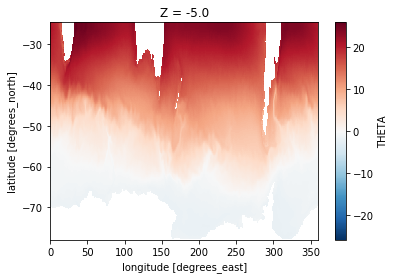

In [8]:
sst_mean.where(surface_mask).plot()

In [9]:
surface_mask

<xarray.DataArray 'hFacC' (YC: 320, XC: 2160)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Z        float32 -5.0

## Surface Box 1

In [10]:
left_lon = 314
upper_lat = -69
right_lon = 315
lower_lat = -70

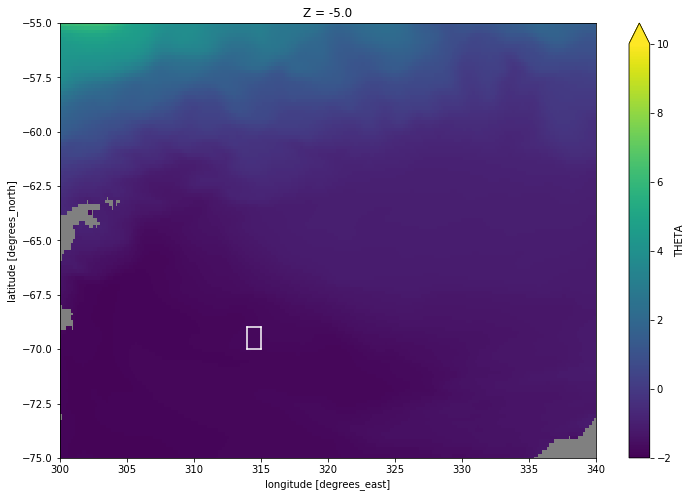

In [11]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
ax.set_xlim([300, 340])
ax.set_ylim([-75, -55]);

In [12]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [13]:
dsr.ADVx_TH.sel(XG=slice(left_lon, right_lon))

<xarray.DataArray 'ADVx_TH' (time: 438, Z: 42, YC: 320, XG: 7)>
dask.array<shape=(438, 42, 320, 7), dtype=float32, chunksize=(1, 42, 320, 7)>
Coordinates:
  * XG       (XG) float32 314.0 314.1667 314.33334 ... 314.6667 314.83334 315.0
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Zonal      Advective Flux of Pot.Temperature
    mate:           ADVy_TH
    standard_name:  ADVx_TH
    units:          degC.m^3/s

In [14]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range, YG=slice(lower_lat, upper_lat)).sum(dim=['XC', 'Z', 'YG']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range, XG=slice(left_lon, right_lon)).sum(dim=['YC', 'Z', 'XG']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([3033179.8,  667927.1, 3571327. , ..., 5162729. , 2219891.2, 7989247.5],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [15]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range, YG=slice(lower_lat, upper_lat)).sum(dim=['XC', 'Z', 'YG']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range, XG=slice(left_lon, right_lon)).sum(dim=['YC', 'Z', 'XG']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([  5719.6543,   3687.166 ,   5063.387 , ..., -28671.44  , -28475.248 ,
       -25753.236 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [16]:
dsr.TFLUX

<xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [17]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([1.171648e+11, 3.334356e+10, 4.560038e+10, ..., 8.222496e+09,
       1.296998e+10, 2.812064e+10], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [18]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (˚C m^3)/s

In [19]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-574178.25 ,   25310.57 , -196450.8  , ...,   92797.375, -315532.47 ,
        104012.1  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

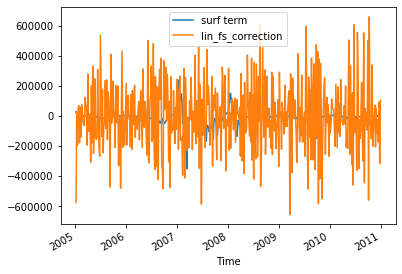

In [20]:
surface_term.plot(label='surf term')
lin_fs_correction.plot(label='lin_fs_correction')
plt.legend();

In [49]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([178366.352593, 155140.314074, 168627.65037 , ..., 167897.220741,
       199673.694815, 341536.237037])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

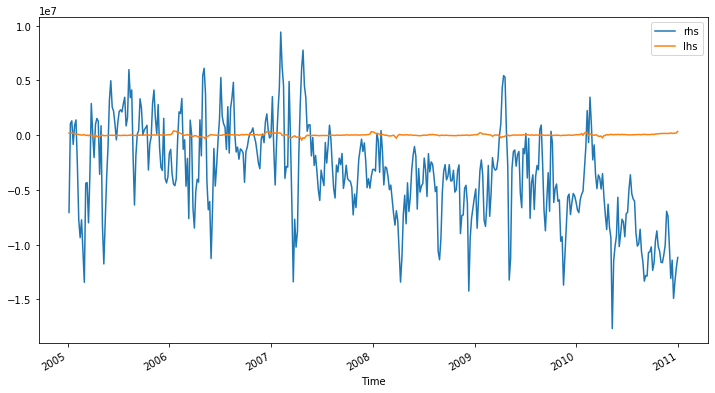

In [50]:
rhs = - adv_flux - diff_flux - lin_fs_correction - surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

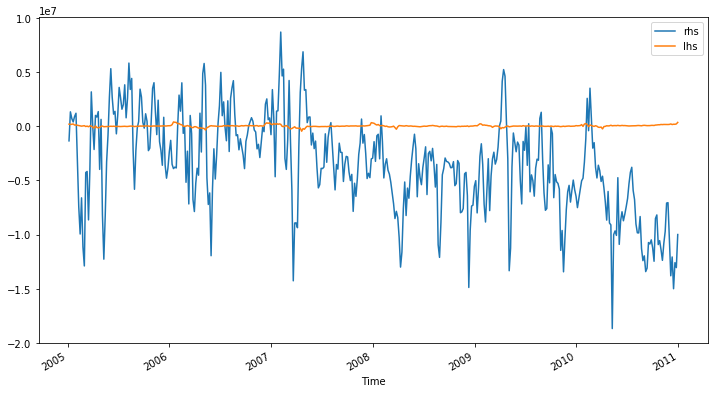

In [51]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

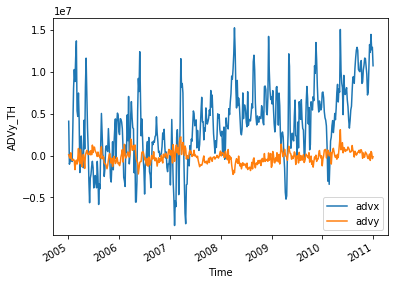

In [52]:
adv_flux_x.plot(label='advx')
adv_flux_y.plot(label='advy')
plt.legend()

In [53]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    tottend    (time) float64 1.784e+05 1.551e+05 ... 1.997e+05 3.415e+05
    adv_flux   (time) float32 4211804.5 -1187323.8 ... 12585567.0 10600847.0
    diff_flux  (time) float32 999.53015 190.08209 ... -12399.787 -11629.154
    lin_fs     (time) float32 2636602.0 -45459.168 ... -524311.25 390653.44
    surface    (time) float32 215669.38 175124.94 ... 45399.684 196011.55

In [54]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,1.052255e+04
adv_flux,3.580424e+06
diff_flux,1.400513e+03
lin_fs,-1.680984e+03
surface,3.260938e+03


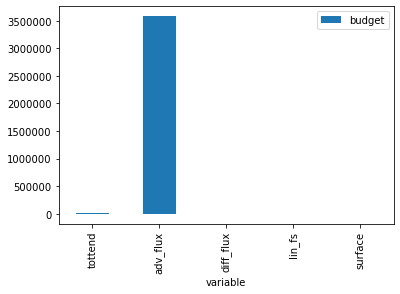

In [55]:
df.plot(kind='bar')

## Surface box 2
could the difference be the regions (region with more ACC current); whereas, the one above is where one would see more meridional transport, no?

In [28]:
left_lon = 320
upper_lat = -65
right_lon = 321
lower_lat = -66

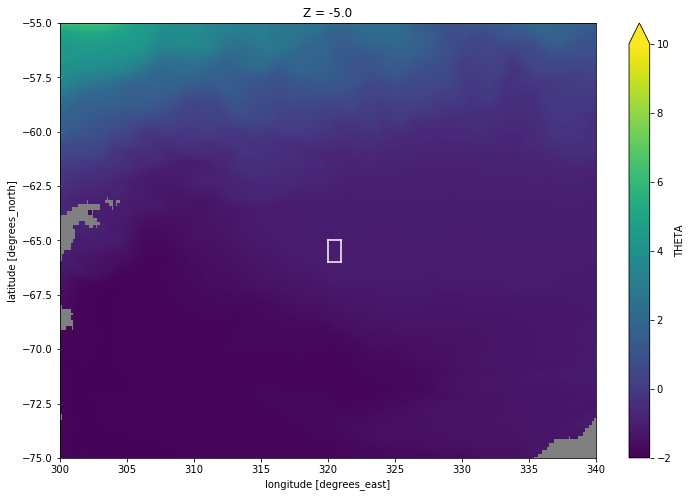

In [29]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
ax.set_xlim([300, 340])
ax.set_ylim([-75, -55]);

In [30]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [31]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range, YG=slice(lower_lat, upper_lat)).sum(dim=['XC', 'Z', 'YG']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range, XG=slice(left_lon, right_lon)).sum(dim=['YC', 'Z', 'XG']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 4211804.5, -1187323.8, -1001609.6, ..., 12997870. , 12585567. ,
       10600847. ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [32]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range, YG=slice(lower_lat, upper_lat)).sum(dim=['XC', 'Z', 'YG']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range, XG=slice(left_lon, right_lon)).sum(dim=['YC', 'Z', 'XG']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([   999.53015,    190.08209,    329.0674 , ..., -13445.267  ,
       -12399.787  , -11629.154  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [33]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([8.915319e+11, 7.239297e+11, 6.731362e+11, ..., 7.646576e+10,
       1.876728e+11, 8.102706e+11], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [34]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (˚C m^3)/s

In [35]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([2636602.   ,  -45459.168, -462985.2  , ...,  368065.84 , -524311.25 ,
        390653.44 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

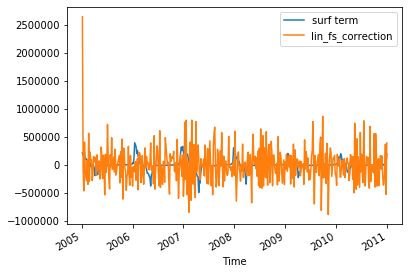

In [36]:
surface_term.plot(label='surf term')
lin_fs_correction.plot(label='lin_fs_correction')
plt.legend();

In [37]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) #/ (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([1.541085e+10, 1.340412e+10, 1.456943e+10, ..., 1.450632e+10,
       1.725181e+10, 2.950873e+10], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

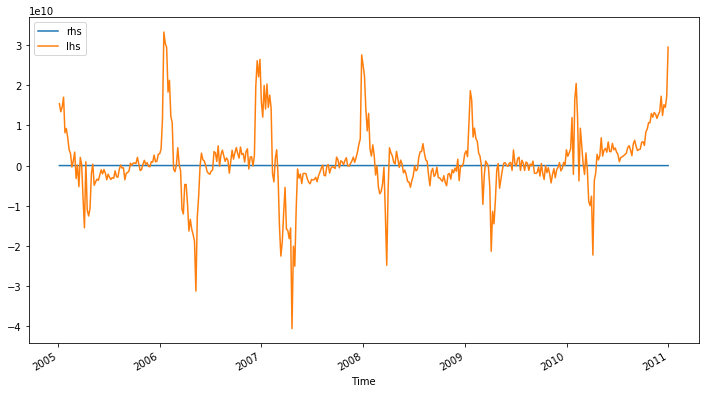

In [38]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

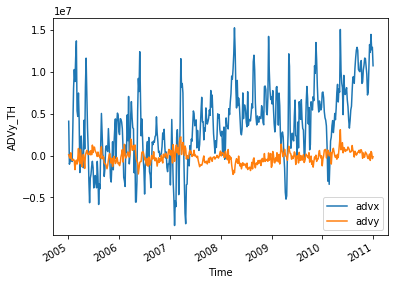

In [39]:
adv_flux_x.plot(label='advx')
adv_flux_y.plot(label='advy')
plt.legend()

In [40]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    tottend    (time) float32 15410853000.0 13404123000.0 ... 29508730000.0
    adv_flux   (time) float32 4211804.5 -1187323.8 ... 12585567.0 10600847.0
    diff_flux  (time) float32 999.53015 190.08209 ... -12399.787 -11629.154
    lin_fs     (time) float32 2636602.0 -45459.168 ... -524311.25 390653.44
    surface    (time) float32 215669.38 175124.94 ... 45399.684 196011.55

In [41]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,9.091485e+08
adv_flux,3.580424e+06
diff_flux,1.400513e+03
lin_fs,-1.680984e+03
surface,3.260938e+03


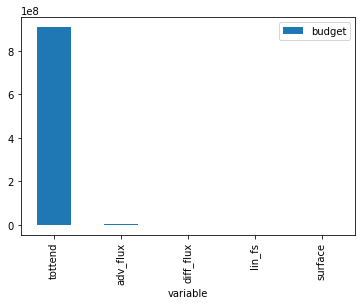

In [42]:
df.plot(kind='bar')

## Interior Box 1

In [43]:
sst_mean_lower = dsr.THETA.sel(Z=slice(-2e03, -5.575e03)).mean(dim=['time', 'Z']).load()

In [44]:
surface_mask_lower = (coords.hFacC.sel(Z=-2046.0)>0).load()

In [45]:
left_lon_lower = 320
upper_lat_lower = -65
right_lon_lower = 321
lower_lat_lower = -66

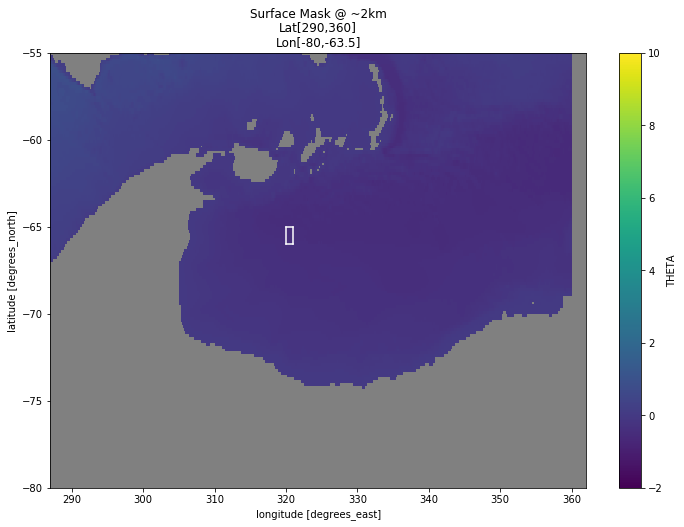

In [46]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon_lower, right_lon_lower], [upper_lat_lower, upper_lat_lower], color='w')
ax.plot([right_lon_lower, right_lon_lower], [lower_lat_lower, upper_lat_lower], color='w')
ax.plot([left_lon_lower, left_lon_lower], [lower_lat_lower, upper_lat_lower], color='w')
ax.plot([left_lon_lower, right_lon_lower], [lower_lat_lower, lower_lat_lower], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [47]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))
lower_cell_range = dict(Z=slice(-2e03, -5.575e03))

In [48]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.sel(**lon_range_lower, YG=slice(lower_lat_lower, upper_lat_lower), 
                                   **lower_cell_range).sum(dim=['XC', 'Z', 'YG']).load()
adv_flux_x_lower = dsr.ADVx_TH.sel(**lat_range_lower, XG=slice(left_lon_lower, right_lon_lower), 
                                   **lower_cell_range).sum(dim=['YC', 'Z', 'XG']).load()
adv_flux_z_lower = dsr.ADVr_TH.sel(**lon_range_lower, **lat_range_lower).sel(
                                              Zl=-2.1e03, method='nearest').sum(dim=['XC', 'YC']).load()
adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

KeyboardInterrupt: 

In [ ]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.sel(**lon_range_lower, YG=slice(lower_lat_lower, upper_lat_lower), 
                                    **lower_cell_range).sum(dim=['XC', 'Z', 'YG']).load()
diff_flux_x_lower = dsr.DFxE_TH.sel(**lat_range_lower, XG=slice(left_lon_lower, right_lon_lower), 
                                    **lower_cell_range).sum(dim=['YC', 'Z', 'XG']).load()
diff_flux_z_lower = (dsr.DFrE_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])
                   + dsr.DFrI_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])
                   + dsr.KPPg_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])).load()

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
tottend_weddell_lower = ((dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).sel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range).sum(
                         dim=['XC', 'YC', 'Z']))/ (24*60*60)

tottend_weddell_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower = tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();
# tried dividing by 24 (too big), then 24*60 (still too big but better), then 24*60*60 but then it's 0. 

In [ ]:
all_terms_lower = xr.merge([tottend_weddell_lower.rename('tottend'),
                      adv_flux_lower.rename('adv_flux'),
                      diff_flux_lower.rename('diff_flux')])
all_terms_lower

In [ ]:
plt.figure(figsize=(12,6))
all_terms_lower.to_array().plot.line(x='time')
plt.grid();

In [ ]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(
                                                                                        name='budget')
df_lower

In [ ]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid();